# Comparing Networks

In this notebook, we want to compare different network to each other.
This one contains

- Untrained Model
- Trained Model
- Trained Model (**Simple Gradient Ascent Unlearning**)*$^1$

There will be a notebook for every approx. MU algorithm

*$^1$ Simple Gradient Ascent: For every sample that we want to unlearn, we will take a step "up the loss function" in the training loop.

In [ ]:
import os
import sys

# Add the parent directory to sys.path
sys.path.append(os.path.join('..', 'src'))

import torch
import copy
from PIL import Image
import numpy as np
# from helper import get_model TODO Muss überarbeitet werden
from mlp_dataclass import MNIST_CostumDataset, TwoLayerPerceptron, ConvNet
from training import main, train_n_models
from helper import load_models_dict

USED_DATASET = "mnist"
# OUT OF: ["mnist", "cmnist", "fashion_mnist"]

ALLREADY_TRAINED = False

all_data = MNIST_CostumDataset(
    sample_mode="all",
    train= True,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)

unlearned_data = MNIST_CostumDataset(
    sample_mode="only_erased",
    train= True,
    test = False,
    classes=["7"],
    dataset_name = USED_DATASET,
    download=True,
)
len(unlearned_data)

c:\Users\Moritz\miniconda3\envs\bach.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


139

In [2]:
def prepare_sample(path:str):
    """preps sample to pass to model, transforms to tensor, reshape to 784, shaping it as batch"""
    sample = Image.open(path).convert("L")
    sample = torch.Tensor(np.array(sample)).reshape(784)
    
    return sample.unsqueeze(0)

def show_sample(sample:torch.Tensor):
    """Converts the sample to a numpy array and reshapes it to a 28x28 image"""
    sample = sample.reshape(28, 28)
    sample = sample.numpy()
    sample = Image.fromarray(sample)
    return sample

____

### Untrained Model

In [ ]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    untrained_showcase_all= TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    untrained_showcase_all = ConvNet()
name = str(untrained_showcase_all)
untrained_showcase_all.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}{name}_showcase_untrained",
        weights_only=True
        )
    )
untrained_ms = load_models_dict(f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")

___

### Trained Model


In [ ]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    trained_showcase_all= TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    trained_showcase_all = ConvNet()
name = str(trained_showcase_all)
trained_showcase_all.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase",
        weights_only=True
        )
    )

In [ ]:
trained_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}test_ensemble")

___

### Simple Gradient Ascent Model


In [ ]:
from unlearning import SimpleGradientAscent
from training import save_model

In [ ]:
# Train a single model first
if not ALLREADY_TRAINED:
    sga = SimpleGradientAscent(
        model=trained_showcase_all,
        unlearned_data=unlearned_data,
        dataset_name=USED_DATASET,
    )
    mu_showcase = sga.unlearn()
    save_model(mu_showcase, name="mu_showcase", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}SimpleGradAsc", logs=False)
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        mu_showcase= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        mu_showcase= ConvNet()
    name = str(mu_showcase)
    mu_showcase.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}SimpleGradAsc{os.sep}{name}_mu_showcase",
            weights_only=True
            )
        )

In [ ]:
if not ALLREADY_TRAINED:
    mu_ms = {}
    for i, model in trained_ms.items():
        sga = SimpleGradientAscent(
            model=model,
            unlearned_data=unlearned_data,
            dataset_name=USED_DATASET,
        )
        mx = sga.unlearn()
        save_model(mx, name="mu_ms", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}SimpleGradAsc{os.sep}test_ensemble", logs=False)
        mu_ms[len(mu_ms)] = mx
else:
    mu_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}SimpleGradAsc{os.sep}test_ensemble")

___

## Metrics

In [9]:
from metrics import calc_accuracy
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

### L2 Norm

Compare how the different models are from each other using the L2 Norm, comparing every parameter with each other

In [10]:
from metrics import model_l2_norm_difference, calc_mutlimodel_metric_average

We can luckily cut down on some calculations, since the **L2-Norm** is symmetrical

#### Unlearn to ...

In [11]:
# ...trained model
a11 = calc_mutlimodel_metric_average(untrained_ms, trained_ms, metric="l2_norm")
a11

27.63682018741965

In [ ]:
# ...exact model
a12 = calc_mutlimodel_metric_average(untrained_ms, mu_ms, metric="l2_norm")
a12

27.64840864042441

#### Trained to ...

In [ ]:
# ...untrained model
a21 = calc_mutlimodel_metric_average(trained_ms, mu_ms, metric="l2_norm")
a21

28.450116612017155

#### Exact to ...

In [14]:
# see above

### KL-Divergence

Used to compare the difference between distribution, but may also be used to compare models by their predicted target distributions.

In [ ]:
from metrics import kl_divergence_between_models, calc_mutlimodel_metric_average
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset=unlearned_data,
    batch_size=8,
    shuffle=False,
)

#### Unlearned to...

In [ ]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.7395783272578562

In [ ]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.03693711008581683

#### Trained to...

In [ ]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

In [ ]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

#### MU to...

In [ ]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

In [ ]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

### Accuracy

- $D_{Gesamt}$
- $D_{Erased}$
- $D_{Remain}$
- $D_{Accuracy Per Class}$

In [ ]:
from visualize import boxplotting_multimodel_eval

accs = {}

Now, let us see what metrics each model has

Starts evaluation for 'mnist'...


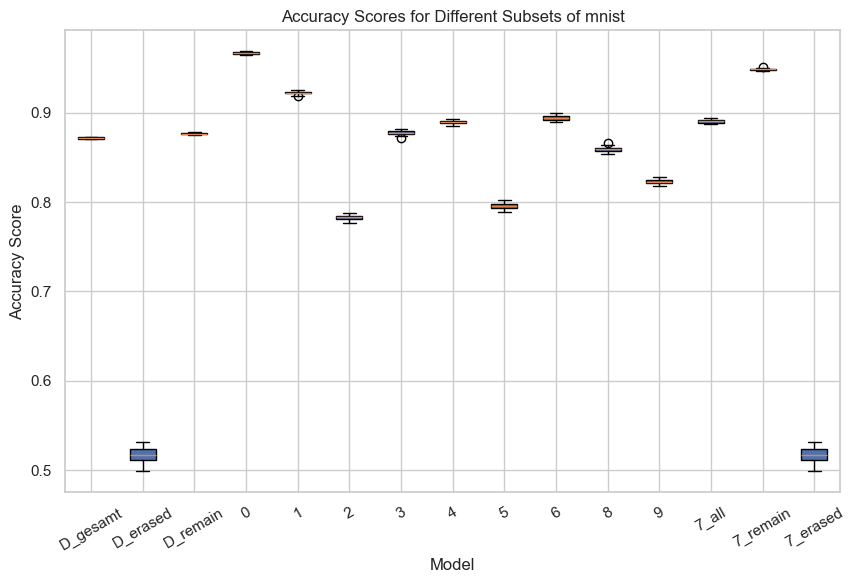

{'D_gesamt': [0.8713428571428572,
  0.8710571428571429,
  0.8710571428571429,
  0.8705428571428572,
  0.8723571428571428,
  0.8727428571428572,
  0.8728428571428571,
  0.8709571428571429,
  0.8706714285714285,
  0.8712142857142857,
  0.8721428571428571,
  0.8723857142857143,
  0.8725142857142857,
  0.8711571428571429,
  0.8709142857142858,
  0.8709,
  0.8702857142857143,
  0.8698285714285714,
  0.8718285714285714,
  0.8701714285714286,
  0.8713285714285715,
  0.8719,
  0.8704571428571428,
  0.8719714285714286,
  0.8705714285714286,
  0.8716857142857143,
  0.8704571428571428,
  0.8724571428571428,
  0.8698,
  0.8723],
 'D_erased': [0.5287588294651867,
  0.515640766902119,
  0.5257315842583249,
  0.5186680121089808,
  0.5116044399596368,
  0.5176589303733602,
  0.5116044399596368,
  0.5065590312815338,
  0.49848637739656915,
  0.5216952573158425,
  0.5216952573158425,
  0.5267406659939455,
  0.5166498486377397,
  0.5307769929364279,
  0.5025227043390514,
  0.5267406659939455,
  0.5136226

In [ ]:
# can take like 80minutes
accs["mu_ms"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="accuracy", logs=True)

#### Losses

In [ ]:
losses = {}

In [ ]:
losses["mu_ms"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="loss", logs=True)